In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 25.6 MB/s eta 0:00:00


# Importing Needed Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
from ultralytics import YOLO
from IPython.display import Video

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

# Loading YOLO Models 


In [4]:
# YOLOV8
model_v8 = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 200MB/s]


In [5]:
# YOLOV11
model_v11 = YOLO("yolo11n.pt")  

100%|██████████| 5.35M/5.35M [00:00<00:00, 203MB/s]


In [6]:
# YOLOV12
model_v12 = YOLO("yolo12n.pt")  

100%|██████████| 5.34M/5.34M [00:00<00:00, 162MB/s]


# Testing Models Before Finetuning


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 5 cars, 85.2ms
Speed: 15.4ms preprocess, 85.2ms inference, 252.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 5 cars, 23.5ms
Speed: 1.9ms preprocess, 23.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 5 cars, 1 truck, 22.1ms
Speed: 1.9ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


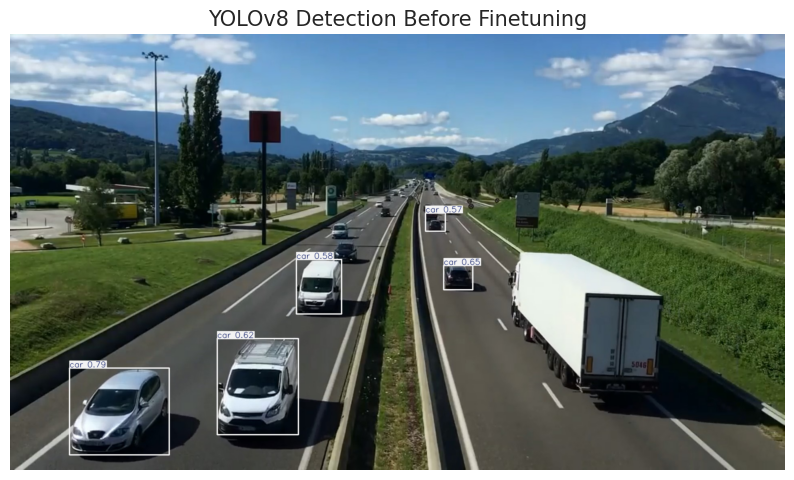

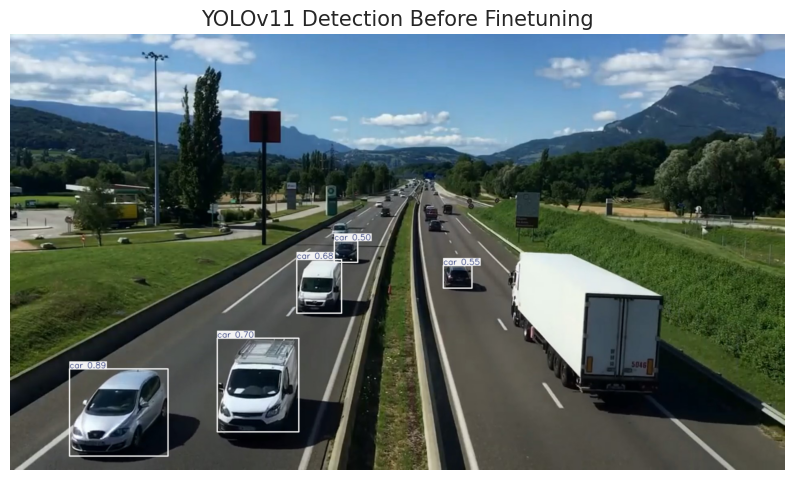

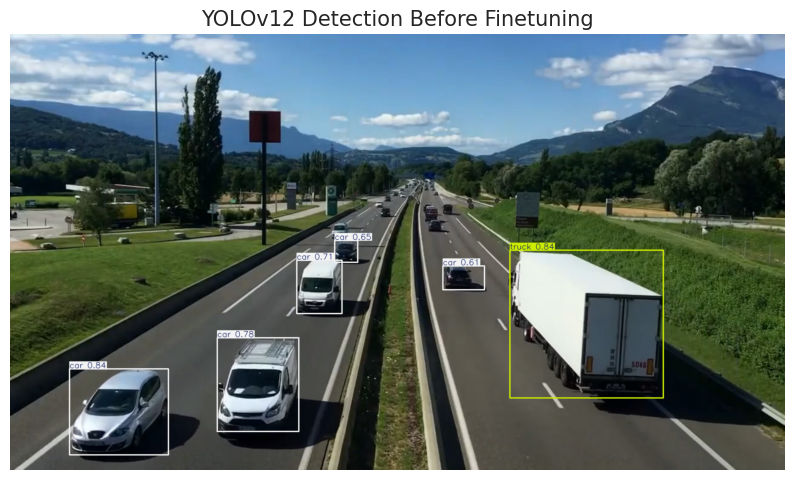

In [7]:
image_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg'

# Predict using YOLOv8
result_v8 = model_v8.predict(
    source=image_path, 
    imgsz=640,  
    conf=0.5
)

# Predict using YOLOv11
result_v11 = model_v11.predict(
    source=image_path, 
    imgsz=640,  
    conf=0.5
)

# Predict using YOLOv12
result_v12 = model_v12.predict(
    source=image_path, 
    imgsz=640,  
    conf=0.5
)

# Plot results from YOLOv8
sample_image_v8 = result_v8[0].plot(line_width=2)
sample_image_v8 = cv2.cvtColor(sample_image_v8, cv2.COLOR_BGR2RGB)

# Plot results from YOLOv11
sample_image_v11 = result_v11[0].plot(line_width=2)
sample_image_v11 = cv2.cvtColor(sample_image_v11, cv2.COLOR_BGR2RGB)

# Plot results from YOLOv12
sample_image_v12 = result_v12[0].plot(line_width=2)
sample_image_v12 = cv2.cvtColor(sample_image_v12, cv2.COLOR_BGR2RGB)

# Display the YOLOv8 result
plt.figure(figsize=(10, 8))
plt.imshow(sample_image_v8)
plt.title('YOLOv8 Detection Before Finetuning', fontsize=15)
plt.axis('off')
plt.show()

# Display the YOLOv11 result
plt.figure(figsize=(10, 8))
plt.imshow(sample_image_v11)
plt.title('YOLOv11 Detection Before Finetuning', fontsize=15)
plt.axis('off')
plt.show()

# Display the YOLOv12 result
plt.figure(figsize=(10, 8))
plt.imshow(sample_image_v12)
plt.title('YOLOv12 Detection Before Finetuning', fontsize=15)
plt.axis('off')
plt.show()


# Prepare Dataset

In [8]:
dataset_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images



In [9]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):  
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'): 
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


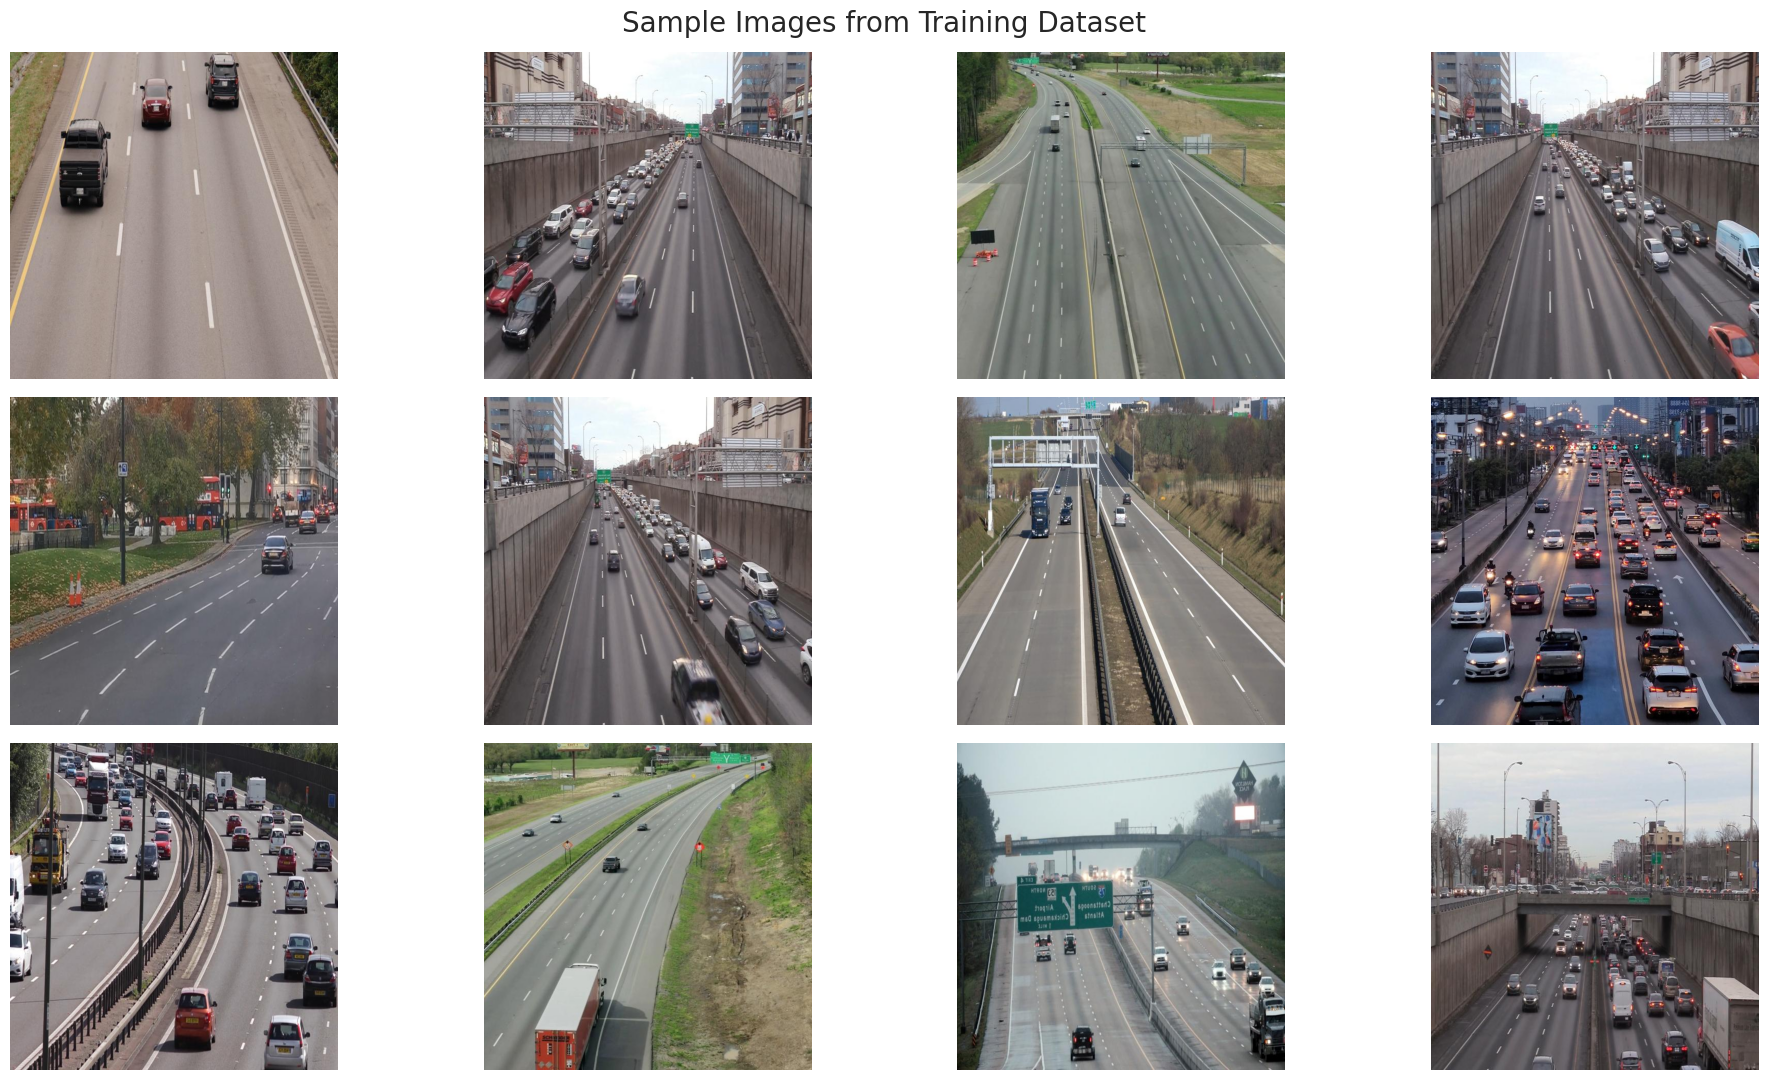

In [10]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 12)]

# Create a 2x4 subplot
fig, axes = plt.subplots(3, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')  

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

# Yolo Models Finetuning 

In [11]:
results_v8 = model_v8.train(
    data=yaml_file_path,     
    epochs=50,              
    imgsz=640,               
    device=0,                 
    patience=20,             
    batch=32,                
    optimizer='Adam'                                       
)

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, epochs=50, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

100%|██████████| 755k/755k [00:00<00:00, 49.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:02<00:00, 264.70it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 186.89it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.23G      2.048      2.311      1.578        319        640: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


                   all         90        937    0.00619      0.178       0.01    0.00369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.29G      1.306     0.9713      1.078        423        640: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         90        937      0.694      0.166      0.261      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.49G      1.243     0.8739      1.052        369        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         90        937      0.248      0.501      0.201      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.64G      1.218     0.8109      1.044        278        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         90        937      0.192       0.63      0.187      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.05G      1.213     0.7818      1.045        289        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         90        937       0.81       0.85      0.892      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.32G      1.198     0.7787      1.031        280        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


                   all         90        937      0.802      0.828      0.872      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.57G      1.155     0.7358      1.023        410        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


                   all         90        937      0.794       0.83      0.881      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.32G      1.146     0.7216      1.021        410        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         90        937      0.859      0.816      0.903      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.34G      1.154      0.717      1.026        358        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


                   all         90        937      0.892      0.859      0.945      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.58G      1.147     0.7071      1.014        385        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


                   all         90        937      0.871      0.875      0.931       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.33G      1.144     0.6997      1.026        396        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         90        937      0.851      0.894       0.94      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.35G      1.112     0.6854      1.006        289        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         90        937      0.888      0.885      0.953      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.53G      1.098     0.6604     0.9985        325        640: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         90        937      0.784      0.895      0.876      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.23G      1.095     0.6742     0.9974        319        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         90        937      0.851      0.915      0.935      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.65G      1.091     0.6683      1.006        353        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         90        937       0.87      0.887      0.938      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.37G      1.107     0.6429      1.006        397        640: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         90        937       0.87      0.919      0.957      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.41G      1.086     0.6359     0.9981        457        640: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         90        937      0.869      0.905      0.952      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.39G      1.061     0.6258     0.9878        324        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         90        937      0.848      0.892      0.941      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.63G       1.07     0.6244     0.9941        278        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         90        937      0.866      0.883      0.942      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.09G      1.071     0.6216          1        390        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         90        937      0.913      0.895      0.965      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.3G      1.059     0.6115     0.9919        365        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         90        937      0.884      0.892      0.953      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.41G      1.045     0.6021     0.9845        410        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         90        937      0.899      0.915      0.967      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.34G      1.056     0.5956     0.9842        329        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         90        937      0.877      0.917      0.965       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.46G      1.049     0.6038     0.9936        319        640: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         90        937      0.858      0.897      0.945      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.17G      1.028     0.5993     0.9806        444        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         90        937      0.843      0.927      0.926      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.66G      1.041     0.5949     0.9797        296        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         90        937      0.887      0.894      0.954       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.32G      1.053     0.6061      0.981        400        640: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         90        937      0.901       0.92      0.967      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.28G      1.019     0.5998     0.9726        344        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


                   all         90        937      0.901      0.868      0.949      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.46G      1.019     0.5808     0.9642        456        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         90        937      0.907       0.91      0.967      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.31G      1.017     0.5642     0.9749        491        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         90        937      0.895      0.905      0.961       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       4.3G      1.006     0.5641     0.9621        341        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         90        937      0.897      0.923      0.962      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.14G      1.007     0.5607     0.9663        331        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


                   all         90        937        0.9      0.905      0.962      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.34G      1.002     0.5552      0.968        361        640: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.891      0.928      0.967      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.31G     0.9948     0.5528     0.9581        426        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         90        937      0.902      0.908      0.966      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.34G     0.9718      0.539      0.952        286        640: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         90        937       0.88       0.93      0.959      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.59G     0.9725      0.527       0.96        399        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         90        937      0.914      0.917      0.973       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.04G     0.9819     0.5399     0.9613        233        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         90        937      0.922        0.9      0.971       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.39G     0.9697      0.537     0.9592        275        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         90        937      0.909      0.917      0.972      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.33G     0.9659     0.5348     0.9522        256        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         90        937        0.9      0.917       0.97      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.38G     0.9708     0.5394     0.9619        381        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         90        937      0.899      0.931      0.969      0.719


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.03G      0.952     0.5063     0.9568        257        640: 100%|██████████| 17/17 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


                   all         90        937      0.913      0.892      0.957      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.98G     0.9466     0.5075     0.9522        233        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         90        937      0.897      0.943       0.97       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.92G     0.9352     0.4975     0.9514        291        640: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


                   all         90        937      0.915      0.922      0.973      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.93G     0.9305     0.4931     0.9492        316        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         90        937      0.886      0.943      0.972      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.89G      0.917     0.4785     0.9502        199        640: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         90        937      0.932       0.93      0.974      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.9G     0.9098     0.4648     0.9447        161        640: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         90        937      0.931      0.925      0.976      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.88G     0.9028     0.4659     0.9504        216        640: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         90        937      0.925       0.92      0.972      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.89G     0.8993     0.4586     0.9434        173        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


                   all         90        937      0.928       0.93      0.971      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.97G     0.8927     0.4524     0.9322        268        640: 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         90        937      0.937      0.923      0.976      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.97G     0.8867     0.4503     0.9337        293        640: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         90        937      0.929      0.919      0.975      0.732



50 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


                   all         90        937      0.929      0.917      0.975      0.732
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


In [12]:
results_v11 = model_v11.train(
    data=yaml_file_path,     
    epochs=50,              
    imgsz=640,               
    device=0,                 
    patience=20,             
    batch=32,                
    optimizer='Adam'                                       
)

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, epochs=50, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:00<00:00, 770.49it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 452.89it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.94G      2.258      2.729      1.738        319        640: 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         90        937      0.008      0.231      0.019    0.00569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       4.8G      1.341      1.075      1.097        423        640: 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


                   all         90        937      0.107      0.485      0.241      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         5G      1.251     0.8657      1.047        369        640: 100%|██████████| 17/17 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


                   all         90        937      0.737      0.662      0.735      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       5.2G      1.228     0.8261      1.049        278        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


                   all         90        937      0.822      0.815      0.879      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.58G      1.218     0.7963       1.04        289        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         90        937      0.834      0.806       0.89      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.85G      1.187     0.7605      1.025        280        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         90        937      0.875      0.845      0.928      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.11G      1.176     0.7565      1.026        410        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         90        937      0.767      0.775      0.822       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.05G      1.165     0.7504      1.023        410        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         90        937      0.857      0.827      0.906      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.87G      1.167     0.7276      1.027        358        640: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         90        937      0.859       0.86      0.932      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.84G      1.131     0.7108      1.008        385        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         90        937      0.856      0.872      0.933      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.88G      1.144     0.7025      1.025        396        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


                   all         90        937      0.861      0.874      0.933      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.81G      1.115     0.6873      1.003        289        640: 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         90        937      0.868       0.87      0.924      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.79G      1.106     0.6537     0.9999        325        640: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         90        937      0.861      0.885      0.938      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.74G      1.111     0.6717     0.9999        319        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


                   all         90        937      0.855      0.873      0.931       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.19G      1.098     0.6636     0.9978        353        640: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         90        937      0.879      0.905      0.955      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.99G      1.098      0.647     0.9946        397        640: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         90        937       0.89      0.889      0.956      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.98G      1.092     0.6354     0.9922        457        640: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


                   all         90        937       0.89      0.886      0.958      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.93G      1.061     0.6206     0.9841        324        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         90        937      0.883      0.891      0.949      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.19G      1.059     0.6207       0.99        278        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         90        937      0.871      0.897      0.957      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.64G      1.069     0.6187     0.9943        390        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         90        937      0.875      0.879      0.954      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.82G      1.068     0.6233     0.9909        365        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


                   all         90        937      0.889      0.863      0.939      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.96G      1.067     0.6187     0.9898        410        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


                   all         90        937      0.879      0.898      0.954      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.88G       1.06     0.6049     0.9838        329        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         90        937      0.914      0.884      0.962      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.02G      1.054     0.6126     0.9888        319        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         90        937      0.881      0.889      0.954      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.66G      1.034     0.6045     0.9771        444        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         90        937       0.92      0.889      0.961      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.22G      1.049     0.6073     0.9795        296        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         90        937      0.893      0.901      0.961      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.85G      1.065     0.6174      0.982        400        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         90        937      0.863      0.918      0.953      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.72G      1.038     0.5904     0.9737        344        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         90        937      0.895      0.895      0.963      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.01G      1.032     0.5854     0.9657        456        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         90        937      0.911      0.899      0.964      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.85G      1.026     0.5724      0.978        491        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         90        937      0.913      0.892      0.963      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.77G      1.012      0.565      0.961        341        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         90        937      0.865      0.934      0.959      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.71G      1.014     0.5592     0.9676        331        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         90        937      0.867      0.935      0.968      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       4.9G      1.008     0.5664     0.9629        361        640: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         90        937      0.932      0.884       0.97      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.84G      1.004     0.5576     0.9602        426        640: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         90        937       0.89      0.888      0.964      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.88G     0.9833     0.5475     0.9521        286        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         90        937      0.892      0.905      0.958      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.12G     0.9857     0.5384      0.963        399        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         90        937      0.917      0.902      0.971      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.56G     0.9898     0.5466     0.9609        233        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         90        937       0.91      0.919      0.964      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.95G     0.9794     0.5524      0.961        275        640: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         90        937      0.903      0.905      0.962       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       4.8G      0.979     0.5465     0.9525        256        640: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         90        937      0.873       0.91      0.966      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.94G     0.9801     0.5501     0.9598        381        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         90        937      0.917      0.901       0.97      0.721


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.52G     0.9638     0.5141     0.9591        257        640: 100%|██████████| 17/17 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         90        937      0.895      0.908      0.967      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.48G     0.9646     0.5106     0.9549        233        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         90        937      0.917      0.916      0.972      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.48G     0.9467     0.4975     0.9537        291        640: 100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         90        937      0.917      0.916       0.97      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.47G     0.9454     0.5025     0.9516        316        640: 100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


                   all         90        937      0.922      0.887      0.969      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.48G     0.9388     0.4957      0.952        199        640: 100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         90        937      0.925      0.924      0.966      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.53G     0.9293      0.482     0.9466        161        640: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         90        937      0.907      0.924      0.971      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.49G     0.9229     0.4806     0.9512        216        640: 100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         90        937      0.933      0.915      0.974      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.51G     0.9203     0.4736      0.947        173        640: 100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         90        937      0.932      0.916      0.977      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.47G     0.9156     0.4662     0.9371        268        640: 100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         90        937       0.91      0.934      0.977      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.47G      0.905     0.4632     0.9373        293        640: 100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         90        937      0.936      0.911      0.977      0.736



50 epochs completed in 0.110 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


                   all         90        937      0.931      0.916      0.977      0.737
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


In [13]:
results_v12 = model_v12.train(
    data=yaml_file_path,     
    epochs=50,              
    imgsz=640,               
    device=0,                 
    patience=20,             
    batch=32,                
    optimizer='Adam'                                       
)

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, epochs=50, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:00<00:00, 782.07it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 396.35it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.63G      2.544      2.846      2.116        319        640: 100%|██████████| 17/17 [00:10<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         90        937     0.0037      0.107     0.0021   0.000496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.64G      1.384      1.096      1.135        423        640: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         90        937      0.288      0.804      0.572      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.84G      1.268     0.8756      1.081        369        640: 100%|██████████| 17/17 [00:10<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         90        937      0.731      0.577       0.67       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.04G      1.244     0.8063      1.081        278        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         90        937      0.672      0.656      0.669      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.42G      1.239     0.8023      1.084        289        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         90        937      0.753      0.779      0.803      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.69G      1.198     0.7563      1.067        280        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


                   all         90        937      0.844      0.841      0.916      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.95G      1.172     0.7361      1.054        410        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         90        937      0.796        0.8      0.866      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.89G      1.164     0.7186      1.054        410        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         90        937       0.83      0.832      0.908      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.71G      1.161     0.7136      1.058        358        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         90        937      0.857      0.847      0.922      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.68G      1.132       0.69      1.039        385        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         90        937      0.833      0.887      0.932      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.72G      1.139     0.6838      1.046        396        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         90        937       0.83      0.886      0.905      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.65G      1.117     0.6743      1.034        289        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.849      0.892      0.942      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.63G      1.125     0.6509      1.035        325        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         90        937      0.759      0.898       0.84      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.58G      1.122     0.6744      1.034        319        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         90        937      0.791      0.899      0.915      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.04G      1.111      0.669       1.04        353        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         90        937      0.831      0.888      0.929      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.83G      1.093     0.6301      1.026        397        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.882      0.899      0.958      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.82G      1.111     0.6316      1.037        457        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         90        937      0.894       0.89      0.952      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.77G      1.074     0.6192      1.019        324        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


                   all         90        937      0.854      0.884       0.94      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.03G       1.07     0.6199      1.021        278        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         90        937      0.845      0.927      0.944      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.47G      1.071     0.6095      1.022        390        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.905      0.895      0.963      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.66G       1.07     0.6139      1.019        365        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


                   all         90        937      0.865      0.874      0.929      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       6.8G      1.065     0.6097      1.016        410        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         90        937      0.887      0.889      0.954      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.72G      1.055        0.6      1.012        329        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


                   all         90        937      0.906      0.878       0.96       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.86G      1.053      0.613      1.017        319        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         90        937      0.854       0.88      0.934      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.52G      1.043     0.6302      1.009        444        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         90        937      0.893       0.91      0.956      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.06G      1.063     0.6188      1.015        296        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         90        937      0.915      0.879      0.963      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.69G      1.066     0.6219      1.012        400        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         90        937      0.872      0.895      0.952      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.56G      1.035      0.594      1.006        344        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         90        937      0.884       0.93      0.968      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.87G       1.03     0.5814     0.9954        456        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         90        937      0.907      0.901      0.963      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.69G      1.019     0.5678      1.001        491        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         90        937      0.893      0.917      0.962      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.62G      1.018      0.571     0.9886        341        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         90        937       0.87      0.933      0.966      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.55G      1.013       0.56     0.9942        331        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         90        937      0.884      0.907      0.965       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.74G      1.014     0.5645     0.9942        361        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.908      0.921      0.969      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.67G       1.02     0.5644     0.9909        426        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         90        937      0.905      0.905      0.965      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.72G     0.9913     0.5464     0.9792        286        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         90        937      0.902       0.89      0.961      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.96G     0.9968     0.5376     0.9925        399        640: 100%|██████████| 17/17 [00:10<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


                   all         90        937       0.91        0.9      0.969      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.41G      1.007     0.5495     0.9892        233        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         90        937      0.902      0.914      0.962      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.79G     0.9841     0.5482     0.9876        275        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         90        937      0.912      0.865      0.957      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.66G       0.99     0.5549     0.9803        256        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         90        937      0.892      0.911      0.963      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.78G     0.9935      0.551      0.989        381        640: 100%|██████████| 17/17 [00:10<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         90        937      0.924      0.898      0.971       0.72


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.51G     0.9758     0.5156     0.9909        257        640: 100%|██████████| 17/17 [00:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


                   all         90        937      0.923      0.904      0.968      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.32G     0.9707     0.5159     0.9839        233        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         90        937      0.931      0.903       0.97       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.32G     0.9696     0.5028      0.992        291        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         90        937      0.932      0.898       0.97      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.32G     0.9551     0.4989     0.9822        316        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         90        937      0.906      0.907      0.969      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.32G     0.9509     0.5002     0.9875        199        640: 100%|██████████| 17/17 [00:10<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         90        937      0.891      0.914      0.967      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.37G      0.945     0.4877     0.9769        161        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         90        937      0.924      0.916      0.974      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.33G     0.9351     0.4843     0.9837        216        640: 100%|██████████| 17/17 [00:10<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         90        937      0.917      0.905      0.964      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.35G     0.9293     0.4761      0.979        173        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         90        937       0.94      0.911      0.975      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.31G     0.9267     0.4716     0.9663        268        640: 100%|██████████| 17/17 [00:10<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         90        937      0.916      0.939      0.973       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.31G     0.9198     0.4665     0.9672        293        640: 100%|██████████| 17/17 [00:10<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         90        937      0.912      0.935      0.974      0.728



50 epochs completed in 0.171 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


                   all         90        937      0.917      0.939      0.974      0.729
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train3


# Comapring Performance 

In [14]:
# Define the path to the directory
post_training_files_path_v8 = '/kaggle/working/runs/detect/train'
post_training_files_path_v11 = '/kaggle/working/runs/detect/train2'
post_training_files_path_v12 = '/kaggle/working/runs/detect/train3'

# # List the files in the directory
# !ls {post_training_files_path_v8}
# !ls {post_training_files_path_v11}

## **Learning Curves**

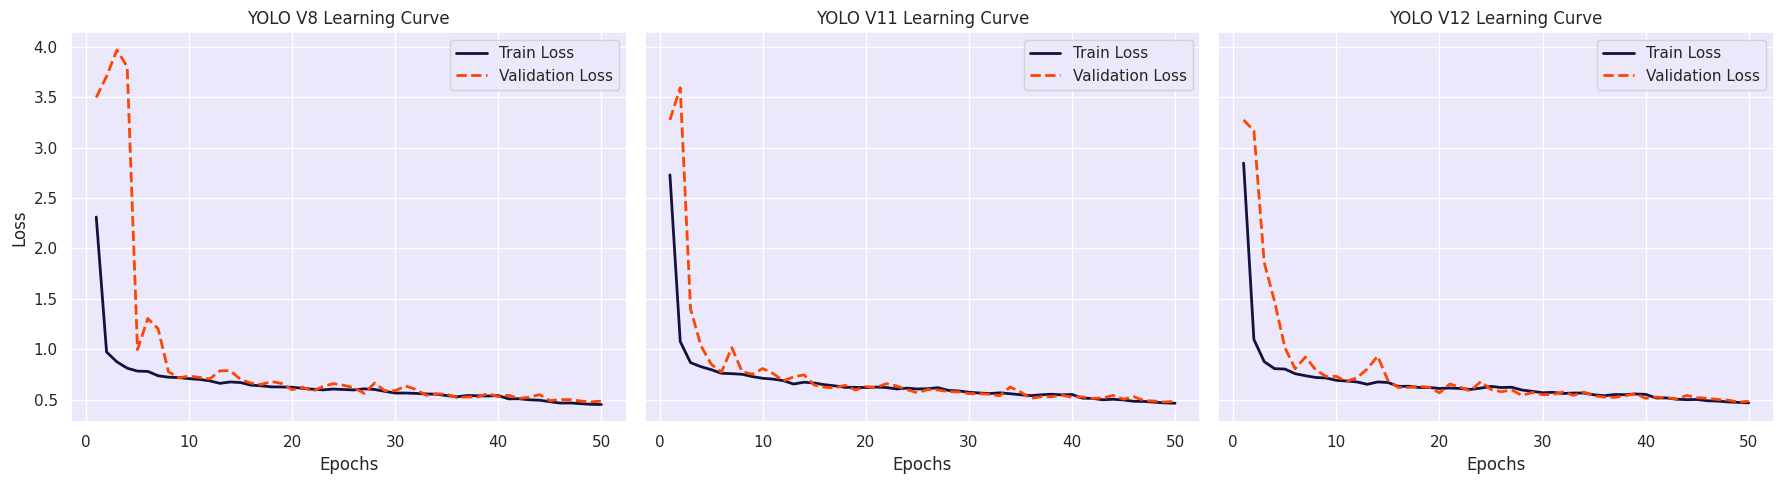

In [15]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, title, ax):
    sns.lineplot(data=df, x='epoch', y='train/cls_loss', label='Train Loss', color='#141140', linestyle='-', linewidth=2, ax=ax)
    sns.lineplot(data=df, x='epoch', y='val/cls_loss', label='Validation Loss', color='orangered', linestyle='--', linewidth=2, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

#Create the full file path for 'results.csv' using the directory path and file name
results_csv_path_v8 = os.path.join(post_training_files_path_v8, 'results.csv')
results_csv_path_v11 = os.path.join(post_training_files_path_v11, 'results.csv')
results_csv_path_v12 = os.path.join(post_training_files_path_v12, 'results.csv')

results_list = [results_csv_path_v8, results_csv_path_v11, results_csv_path_v12]
texts_list = ['YOLO V8 Learning Curve', 'YOLO V11 Learning Curve', 'YOLO V12 Learning Curve']
# Create a figure with subplots
fig, axes = plt.subplots(1, len(results_list), figsize=(18, 5), sharex=True, sharey=True)
for ax, result, text in zip(axes, results_list, texts_list):
    df= pd.read_csv(result)
    plot_learning_curve(df, text, ax)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## **Confusion Matrix**

In [16]:
# confusion_matrix_path_v8 = os.path.join(post_training_files_path_v8, 'confusion_matrix.png')
# confusion_matrix_path_v11 = os.path.join(post_training_files_path_v11, 'confusion_matrix.png')
# confusion_matrix_path_v12 = os.path.join(post_training_files_path_v12, 'confusion_matrix.png')

# cm_img_v8 = cv2.imread(confusion_matrix_path_v8)
# cm_img_v8 = cv2.cvtColor(cm_img_v8, cv2.COLOR_BGR2RGB)

# cm_img_v11 = cv2.imread(confusion_matrix_path_v11)
# cm_img_11 = cv2.cvtColor(cm_img_v11, cv2.COLOR_BGR2RGB)

# cm_img_v12 = cv2.imread(confusion_matrix_path_v12)
# cm_img_12 = cv2.cvtColor(cm_img_v12, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(10, 10), dpi=120)
# plt.imshow(cm_img_v8)
# plt.axis('off') 
# plt.show()

# plt.figure(figsize=(10, 10), dpi=120)
# plt.imshow(cm_img_v11)
# plt.axis('off') 
# plt.show()

# plt.figure(figsize=(10, 10), dpi=120)
# plt.imshow(cm_img_v12)
# plt.axis('off') 
# plt.show()

# # Plot each confusion matrix image
# for ax, img_path, title in zip(axes, confusion_matrix_paths, titles):
#     plot_confusion_matrix(img_path, title, ax)

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


## **Metrics**

In [17]:
best_model_path_v8 = os.path.join(post_training_files_path_v8, 'weights/best.pt')
best_model_path_v11 = os.path.join(post_training_files_path_v11, 'weights/best.pt')
best_model_path_v12 = os.path.join(post_training_files_path_v12, 'weights/best.pt')

best_model_v8 = YOLO(best_model_path_v8)
best_model_v11 = YOLO(best_model_path_v11)
best_model_v12 = YOLO(best_model_path_v12)

metrics_v8 = best_model_v8.val(split='val')
print('--------------------------------------------------------------------')
metrics_v11 = best_model_v11.val(split='val')
print('--------------------------------------------------------------------')
metrics_v12 = best_model_v12.val(split='val')

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 744.40it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


                   all         90        937      0.929      0.918      0.975      0.734
Speed: 3.7ms preprocess, 5.2ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/val
--------------------------------------------------------------------
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 843.11it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


                   all         90        937      0.932      0.915      0.977      0.735
Speed: 3.8ms preprocess, 9.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val2
--------------------------------------------------------------------
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 834.22it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


                   all         90        937      0.917      0.939      0.974      0.729
Speed: 3.2ms preprocess, 4.5ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/val3


In [18]:
metrics_df_v8 = pd.DataFrame.from_dict(metrics_v8.results_dict, orient='index', columns=['Metric Value YOLOV8'])
print(metrics_df_v8.head(2).round(3))

metrics_df_v11 = pd.DataFrame.from_dict(metrics_v11.results_dict, orient='index', columns=['Metric Value YOLOV11'])
print(metrics_df_v11.head(2).round(3))

metrics_df_v12 = pd.DataFrame.from_dict(metrics_v12.results_dict, orient='index', columns=['Metric Value YOLOV12'])
print(metrics_df_v12.head(2).round(3))

                      Metric Value YOLOV8
metrics/precision(B)                0.929
metrics/recall(B)                   0.918
                      Metric Value YOLOV11
metrics/precision(B)                 0.932
metrics/recall(B)                    0.915
                      Metric Value YOLOV12
metrics/precision(B)                 0.917
metrics/recall(B)                    0.939


# Testing Models After Finetuning 


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 8 Vehicles, 11.1ms
Speed: 3.4ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 6 Vehicles, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 6 Vehicles, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/images/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg: 640x640 20 Vehicles, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 64

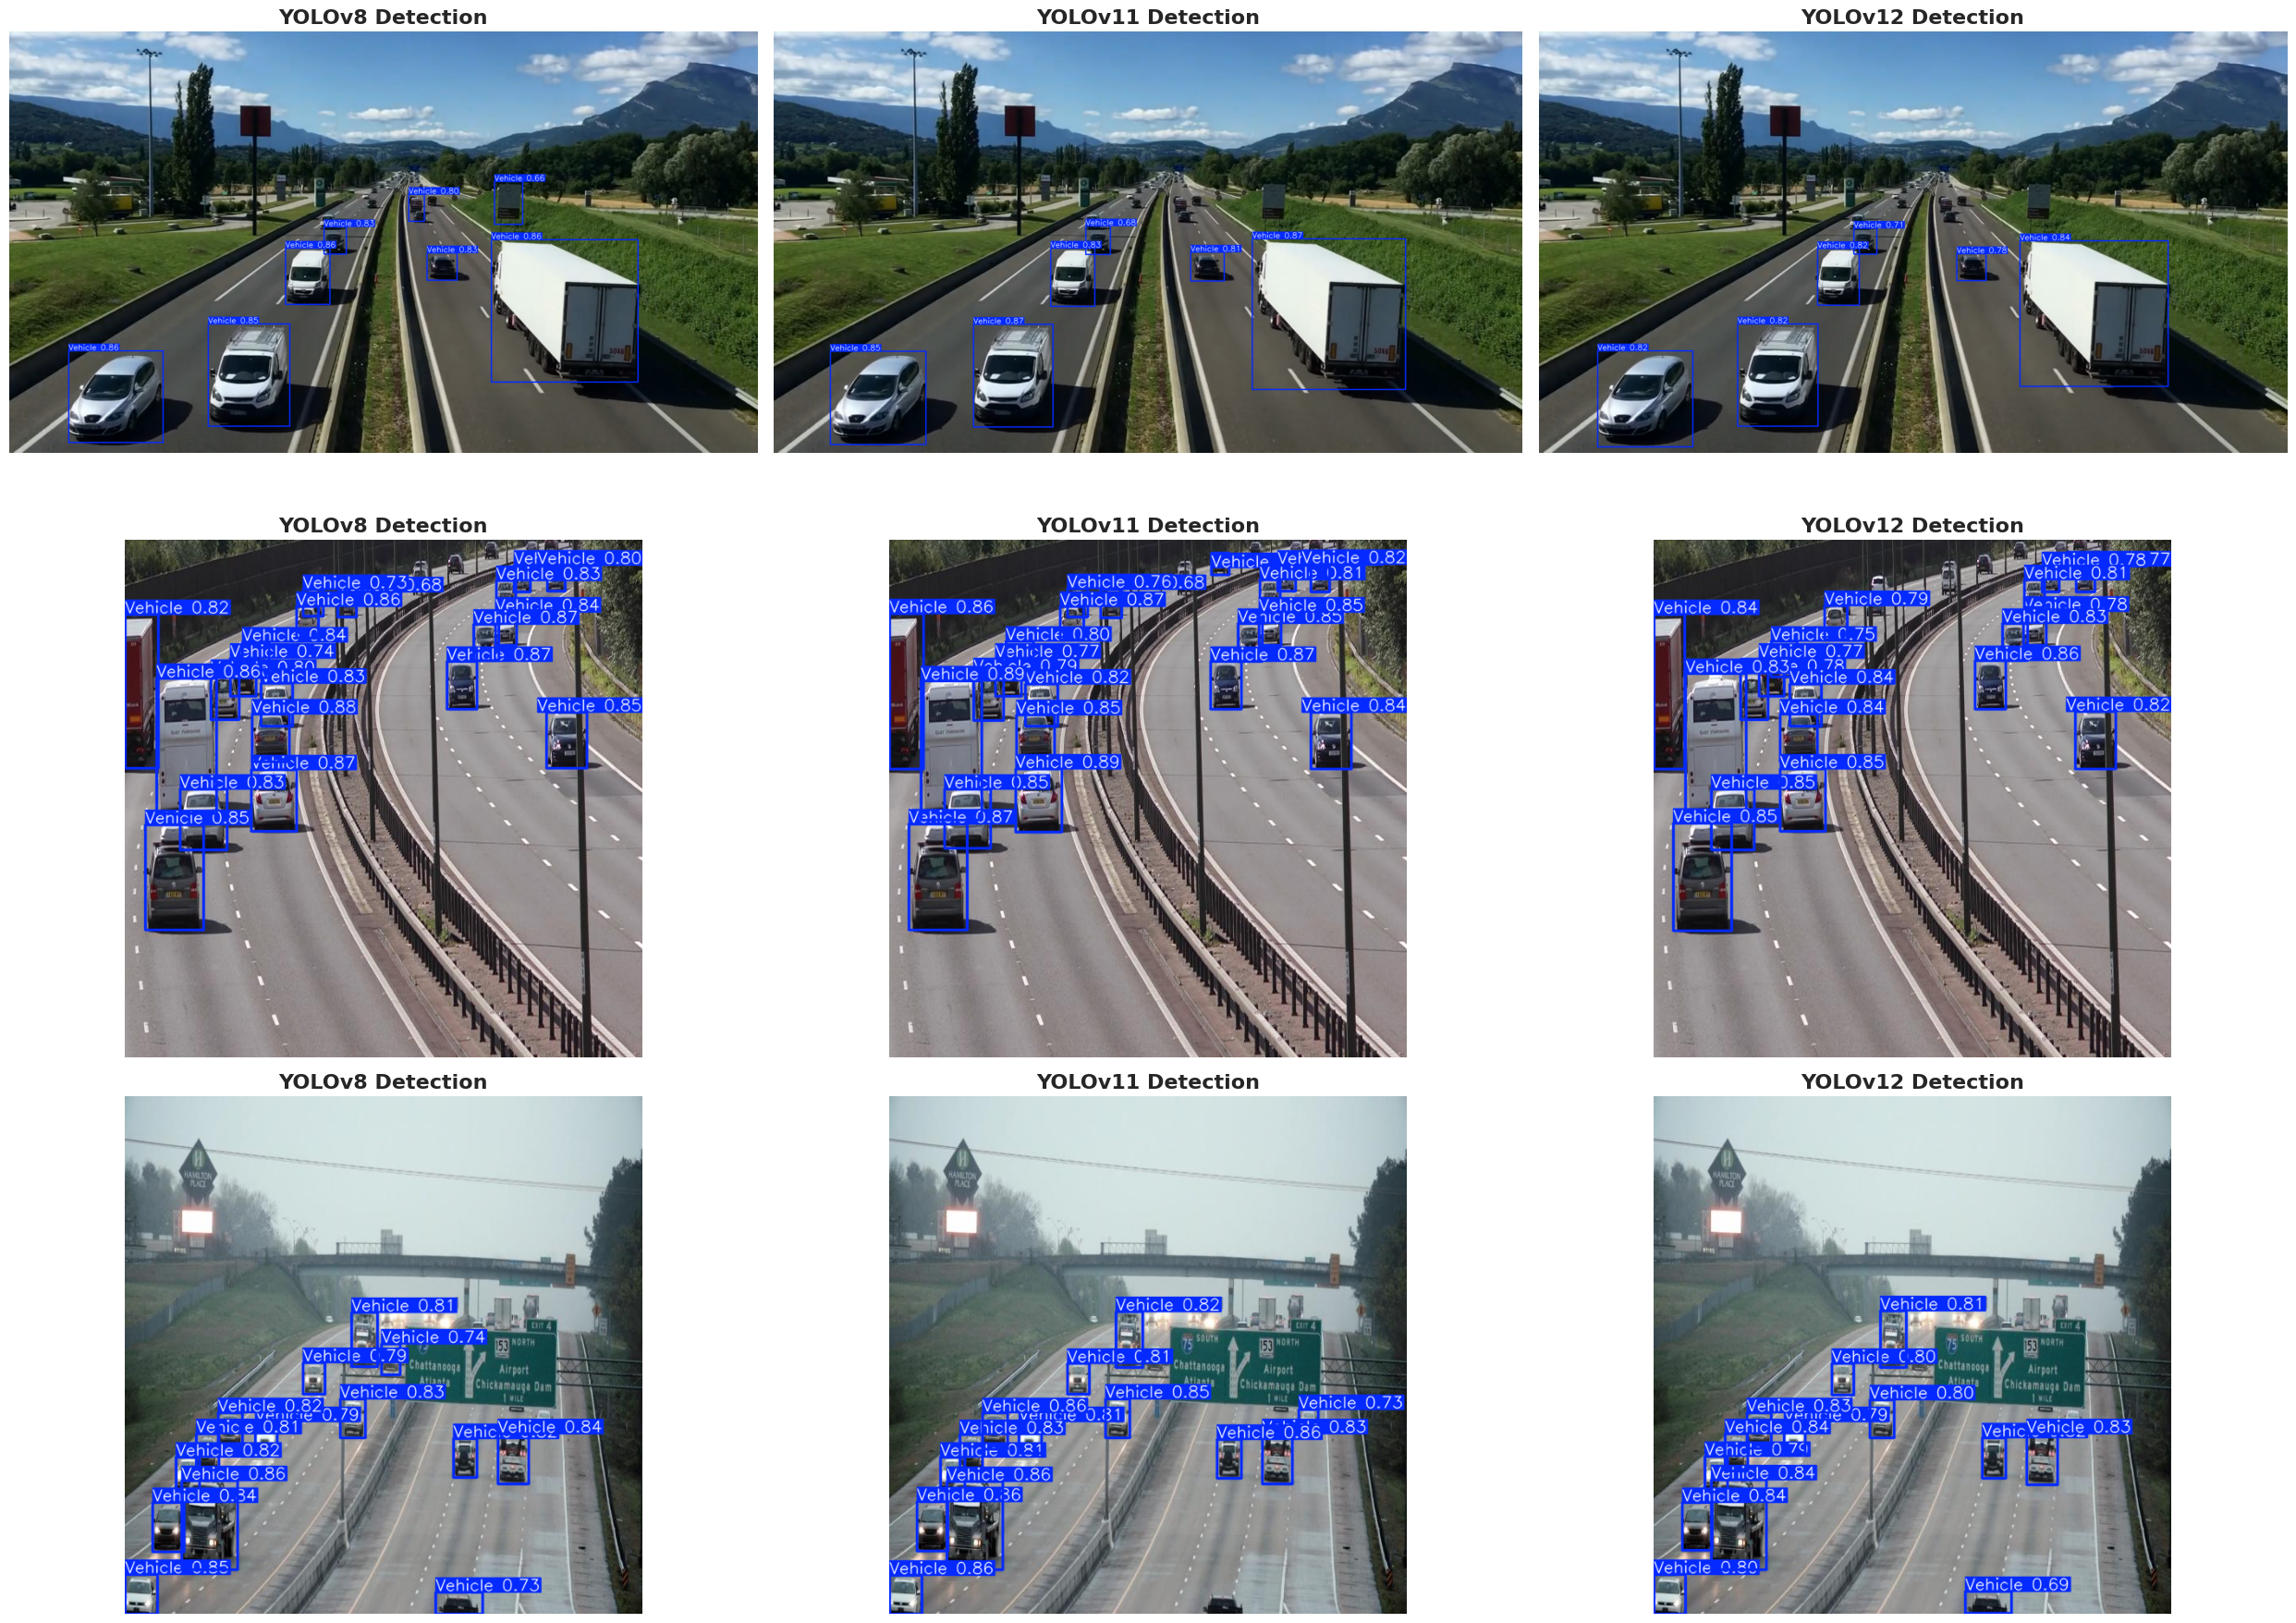

In [19]:
import matplotlib.pyplot as plt
import cv2

# List of sample image paths
sample_image_paths = [
    '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/sample_image.jpg',
    '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/images/10_mp4-0_jpg.rf.08b3bd34bbb73fb80c2d662c34474a98.jpg',
    '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/images/11_mp4-7_jpg.rf.c29830bf45870c97e8667ce13c0994a9.jpg',
]  # Add more paths as needed

# Number of images
num_images = len(sample_image_paths)

# Create a figure with subplots (rows = number of images, columns = 3 models)
fig, axes = plt.subplots(num_images, 3, figsize=(25, 6 * num_images))

# Model list for iteration
models = [best_model_v8, best_model_v11, best_model_v12]
model_names = ['YOLOv8', 'YOLOv11', 'YOLOv12']

# Loop through each image
for i, image_path in enumerate(sample_image_paths):
    # Perform predictions with each model
    results = [model.predict(source=image_path, imgsz=640, conf=0.65) for model in models]
    
    # Process and display results for each model
    for j, result in enumerate(results):
        # Get the plotted image
        plotted_image = result[0].plot(line_width=2)

        # Convert BGR to RGB
        plotted_image = cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB)

        # Plot the image in the corresponding subplot
        ax = axes[i, j] if num_images > 1 else axes[j]  # Handle single image case
        ax.imshow(plotted_image)
        ax.set_title(f"{model_names[j]} Detection", fontsize=16, fontweight='bold')
        ax.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()
